#### Fetching the data

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sidd1996","key":"411008e9f7f47955a0869b805c7a7240"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
!kaggle competitions download -c m5-forecasting-accuracy 

 32% 5.00M/15.5M [00:00<00:00, 49.5MB/s]
100% 15.5M/15.5M [00:00<00:00, 99.4MB/s]
 57% 9.00M/15.8M [00:00<00:00, 42.2MB/s]
100% 15.8M/15.8M [00:00<00:00, 52.7MB/s]
  0% 0.00/163k [00:00<?, ?B/s]
100% 163k/163k [00:00<00:00, 51.3MB/s]
  0% 0.00/101k [00:00<?, ?B/s]
100% 101k/101k [00:00<00:00, 91.2MB/s]
 77% 11.0M/14.2M [00:00<00:00, 43.8MB/s]
100% 14.2M/14.2M [00:00<00:00, 47.4MB/s]


In [ ]:
!unzip -q /content/sales_train_validation.csv.zip 
!unzip -q /content/sell_prices.csv.zip 
!unzip -q /content/sales_train_evaluation.csv.zip
!unzip -q /content/sample_submission.csv.zip

In [ ]:
!pip install dask
!pip install 'fsspec>=0.3.3'
!pip install partd

     |████████████████████████████████| 112kB 5.1MB/s 


In [ ]:
import os
# import gc
import time
import math
import datetime
from math import log, floor
# from sklearn.neighbors import KDTree

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm as tqdm
from sklearn.externals import joblib
import pickle

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

# import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal
import statsmodels.api as sm
from fbprophet import Prophet
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import gc 

import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
sales = pd.read_csv('/content/sales_train_evaluation.csv')
calendar = pd.read_csv('/content/calendar.csv')
sell_prices = pd.read_csv('/content/sell_prices.csv')


In [ ]:
# Ref. link :- https://www.kaggle.com/anshuls235/time-series-forecasting-eda-fe-modelling#6.-Modelling-and-Prediction
#Add zero sales for the remaining days 1942-1969
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)

## Business Problem :-
M5 Forecasting Accuracy is a competetion in which we have to forecast future sales of each product in each store based on the hierarchical sales data provided by Walmart. In this competetion we have to forecast daily sales for next 28 days. Here we have the data for 3 states in US(California, Texas, and Wisconsin).
The data files (.csv files) provided for the competetion consists of item level, department, product categories,items sold on a day, store details, price, promotions, day of the week, and special events.
So by using this data we will forecast daily sales for next 28 days as accurately as possible.


## ML formulation :-
We will do some data preprocessing and feature engineering to get desired format and some new features respectively . Once the data is ready we will pass it through different machine learning and deep learning models . After the model is trained we will predict the values for test dataset.
We will pose this as a supervised machine learning regression problem. In this problem we will be using LGBMRegressor, Facebook Prophet and a deep learning model.

## Metrics :-

The performance measures are first computed for each series separately by averaging their values across the forecasting horizon and then averaged again across the series in a weighted fashion .

Forcasting horizon or number of days for which forecast is required is 28 days.

The metric used for evaluating the accuracy of the each series is Root Mean Squared Scaled Error (RMSSE).  


After estimating the RMSSE for all the 42,840 time series of the competition, we will calculate Weighted RMSSE (WRMSSE) which will be used as our final metric .

The formulas for RMSSE and WRMSSE are given below :-


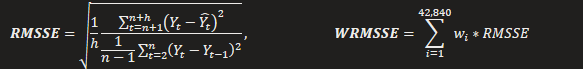


RMSSE variables :- Y_t is the actual future value of the examined time series at point t, (Y_t^)the generated forecast, n the length of the training sample (number of historical observations), and h the forecasting horizon. 

WRMSSE variables :- w_i is the weight of the i_th series of the competition. A lower WRMSSE score is better.Explaination on how to calculate w_i is given in the pdf present in M5 Participants Guide :- https://mofc.unic.ac.cy/m5-competition/ .



## Downcasting

In [ ]:
### Ref link :- https://www.kaggle.com/anshuls235/time-series-forecasting-eda-fe-modelling/comments#1.-Fetch-the-data


#Downcast in order to save memory
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  


In [ ]:
sales = downcast(sales)
sell_prices = downcast(sell_prices)
calendar = downcast(calendar)

In [ ]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941,d_1942,d_1943,d_1944,d_1945,d_1946,d_1947,d_1948,d_1949,d_1950,d_1951,d_1952,d_1953,d_1954,d_1955,d_1956,d_1957,d_1958,d_1959,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,2,4,0,0,0,0,3,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,2,0,0,0,2,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,4,0,1,3,0,2,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,2,0,0,0,2,1,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
sales = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id','state_id'], var_name='d', value_name='sold').dropna()

In [ ]:
sales

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
...,...,...,...,...,...,...,...,...
60034805,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1969,0
60034806,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1969,0
60034807,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1969,0
60034808,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1969,0


In [ ]:
sell_prices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.000000
6841117,WI_3,FOODS_3_827,11618,1.000000
6841118,WI_3,FOODS_3_827,11619,1.000000
6841119,WI_3,FOODS_3_827,11620,1.000000


In [ ]:
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
df = pd.merge(sales, calendar,how = "left",on = 'd')

In [ ]:
df = pd.merge(df, sell_prices, how = 'left', on = ['store_id','item_id','wm_yr_wk'])

In [ ]:
df['sell_price'].fillna(0 , inplace = True)

In [ ]:
df['revenue'] = df['sold'] * df['sell_price']

In [ ]:
df

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,revenue
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.000000,0.0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.000000,0.0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.000000,0.0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.000000,0.0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60034805,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1969,0,2016-06-19,11621,Sunday,2,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,2.980469,0.0
60034806,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1969,0,2016-06-19,11621,Sunday,2,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,2.480469,0.0
60034807,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1969,0,2016-06-19,11621,Sunday,2,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,3.980469,0.0
60034808,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1969,0,2016-06-19,11621,Sunday,2,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,1.280273,0.0


## Feature Engineering


In [ ]:
df = downcast(df)

In [ ]:
df

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,revenue
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.000000,0.0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.000000,0.0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.000000,0.0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.000000,0.0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60034805,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1969,0,2016-06-19,11621,Sunday,2,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,2.980469,0.0
60034806,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1969,0,2016-06-19,11621,Sunday,2,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,2.480469,0.0
60034807,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1969,0,2016-06-19,11621,Sunday,2,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,3.980469,0.0
60034808,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1969,0,2016-06-19,11621,Sunday,2,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,1.280273,0.0


### Lags :-
The past values are known as lags. We use lags to get the correlation between present values and past values, as past values are important to make predictions.

We will get Lag values for 1 day , 7 days and 30 days to get daily , weekly and monthly lags respectively.

In [ ]:
# Ref. link :- https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/150255

df['lag_7'] = df.groupby(['id'])['sold'].apply(lambda x: x.shift(7))

df['lag_21'] = df.groupby(['id'])['sold'].apply(lambda x: x.shift(21))

df['lag_28'] = df.groupby(['id'])['sold'].apply(lambda x: x.shift(28))

df['lag_35'] = df.groupby(['id'])['sold'].apply(lambda x: x.shift(35))

df['lag_42'] = df.groupby(['id'])['sold'].apply(lambda x: x.shift(42))

In [ ]:
## Ref.link :- https://www.kaggle.com/nemuritarinai/m5-accuracy

df['price_lag'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['sell_price'].shift(7).astype(np.float16)

df['price-diff']=df['price_lag']-df['sell_price']

df.drop(['price_lag'], axis=1, inplace=True)

### Rolling / Sliding Window :-

In this we use the past values to calculate statistical values. This is called rolling/sliding window because the window which is used to calculate these statistical value changes for every datapoint.

In [ ]:
window = 28 

For every item in every store

In [ ]:
# Mean
df['rolling_sold_mean_7'] = df.groupby(['id'])['sold'].apply(lambda x: x.shift(window).rolling(window=7).mean()).astype(np.float16) 

df['rolling_sold_mean_14'] = df.groupby(['id'])['sold'].apply(lambda x: x.shift(window).rolling(window=14).mean()).astype(np.float16) 

df['rolling_sold_mean_28'] = df.groupby(['id'])['sold'].apply(lambda x: x.shift(window).rolling(window=28).mean()).astype(np.float16) 

df['rolling_sold_mean_90'] = df.groupby(['id'])['sold'].apply(lambda x: x.shift(window).rolling(window=90).mean()).astype(np.float16) 


# Max
df['rolling_sold_max_7'] = df.groupby(['id'])['sold'].apply(lambda x: x.shift(window).rolling(window=7).max()).astype(np.float16) 

df['rolling_sold_max_28'] = df.groupby(['id'])['sold'].apply(lambda x: x.shift(window).rolling(window=28).max()).astype(np.float16) 

# df['rolling_sold_max_365'] = df.groupby(['id'])['sold'].apply(lambda x: x.rolling(window=365).max()).astype(np.float16) 

# STD
df['rolling_sold_std_7'] = df.groupby(['id'])['sold'].apply(lambda x: x.shift(window).rolling(window=7).std()).astype(np.float16) 

df['rolling_sold_std_28'] = df.groupby(['id'])['sold'].apply(lambda x: x.shift(window).rolling(window=28).std()).astype(np.float16)

df['rolling_sold_std_90'] = df.groupby(['id'])['sold'].apply(lambda x: x.shift(window).rolling(window=90).std()).astype(np.float16)



In [ ]:
# # Mean
# df['rolling_revenue_mean_7'] = df.groupby(['id'])['revenue'].apply(lambda x: x.rolling(window=7).mean()).astype(np.float16) 

df['rolling_revenue_mean_28'] = df.groupby(['id'])['revenue'].apply(lambda x: x.shift(window).rolling(window=28).mean()).astype(np.float16) 

# df['rolling_revenue_mean_90'] = df.groupby(['id'])['revenue'].apply(lambda x: x.rolling(window=90).mean()).astype(np.float16) 


# # Max
# df['rolling_revenue_max_7'] = df.groupby(['id'])['revenue'].apply(lambda x: x.rolling(window=7).max()).astype(np.float16) 

df['rolling_revenue_max_28'] = df.groupby(['id'])['revenue'].apply(lambda x: x.shift(window).rolling(window=28).max()).astype(np.float16) 

# df['rolling_revenue_max_365'] = df.groupby(['id'])['revenue'].apply(lambda x: x.rolling(window=365).max()).astype(np.float16) 

# # STD
# df['rolling_revenue_std_7'] = df.groupby(['id'])['revenue'].apply(lambda x: x.rolling(window=7).std()).astype(np.float16) 

df['rolling_revenue_std_28'] = df.groupby(['id'])['revenue'].apply(lambda x: x.shift(window).rolling(window=28).std()).astype(np.float16)

# df['rolling_revenue_std_90'] = df.groupby(['id'])['revenue'].apply(lambda x: x.rolling(window=90).std()).astype(np.float16)



In [ ]:
# # Mean

# df['rolling_item_revenue_mean_7'] = df.groupby(['item_id'])['revenue'].apply(lambda x: x.rolling(window=7).mean()).astype(np.float16) 

df['rolling_item_revenue_mean_28'] = df.groupby(['item_id'])['revenue'].apply(lambda x: x.shift(window).rolling(window=28).mean()).astype(np.float16) 

In [ ]:
# # Mean

df['rolling_item_sold_mean_7'] = df.groupby(['item_id'])['sold'].apply(lambda x: x.shift(window).rolling(window=7).mean()).astype(np.float16) 

df['rolling_item_sold_mean_28'] = df.groupby(['item_id'])['sold'].apply(lambda x: x.shift(window).rolling(window=28).mean()).astype(np.float16) 


In [ ]:
# # Mean

df['rolling_dept_sold_mean_28'] = df.groupby(['dept_id'])['sold'].apply(lambda x: x.shift(window).rolling(window=28).mean()).astype(np.float16) 

df['rolling_store_sold_mean_28'] = df.groupby(['store_id'])['sold'].apply(lambda x: x.shift(window).rolling(window=28).mean()).astype(np.float16) 

Some other statistical features

In [ ]:
# Average 

df['item_sold_avg'] = df.groupby('item_id')['sold'].transform('mean').astype(np.float16)
df['store_sold_avg'] = df.groupby('store_id')['sold'].transform('mean').astype(np.float16)
df['state_sold_avg'] = df.groupby('state_id')['sold'].transform('mean').astype(np.float16)


df['store_item_sold_avg'] = df.groupby(['store_id','item_id'])['sold'].transform('mean').astype(np.float16) 

df['cat_item_sold_avg'] = df.groupby(['cat_id','item_id'])['sold'].transform('mean').astype(np.float16)

df['state_item_sold_avg'] = df.groupby(['state_id','item_id'])['sold'].transform('mean').astype(np.float16)

df['store_weekday_sold_avg'] = df.groupby(['store_id','weekday'])['sold'].transform('mean').astype(np.float16)

In [ ]:
# Ref. link :- https://www.kaggle.com/kyakovlev/m5-simple-fe
df['max_price'] = df.groupby(['item_id'])['sell_price'].transform('max').astype(np.float16) 
df['min_price'] = df.groupby(['item_id'])['sell_price'].transform('min').astype(np.float16) 

df['price_mean'] = df.groupby(['item_id'])['sell_price'].transform('mean').astype(np.float16) 

df['price_std'] = df.groupby(['item_id'])['sell_price'].transform('std').astype(np.float16) 

df['price_norm'] =  df['sell_price']/df['max_price']

In [ ]:
## Ref.link :- https://www.kaggle.com/nemuritarinai/m5-accuracy

df['daily_avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d'])['sell_price'].transform('mean').astype(np.float16)

df['avg_sold'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sell_price'].transform('mean').astype(np.float16)


df['selling_trend'] = (df['daily_avg_sold'] - df['avg_sold']).astype(np.float16)

### Expanding window :- 
This is an advanced version of rolling windows. In this the window which is used to calculate statistical values increases. The idea behind expanding window is that it takes all the past values into account. 

In [ ]:
df['expanding_sold_mean'] = df.groupby(['id'])['sold'].apply(lambda x: x.expanding(2).mean()).astype(np.float16) 

In [ ]:
df['expanding_revenue_mean'] = df.groupby(['id'])['revenue'].apply(lambda x: x.expanding(2).mean()).astype(np.float16) 

In [ ]:
df

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,revenue,lag_7,lag_21,lag_28,lag_35,lag_42,price-diff,rolling_sold_mean_7,rolling_sold_mean_14,rolling_sold_mean_28,rolling_sold_mean_90,rolling_sold_max_7,rolling_sold_max_28,rolling_sold_std_7,rolling_sold_std_28,rolling_sold_std_90,rolling_revenue_mean_28,rolling_revenue_max_28,rolling_revenue_std_28,rolling_item_revenue_mean_28,rolling_item_sold_mean_7,rolling_item_sold_mean_28,rolling_dept_sold_mean_28,rolling_store_sold_mean_28,item_sold_avg,store_sold_avg,state_sold_avg,store_item_sold_avg,cat_item_sold_avg,state_item_sold_avg,store_weekday_sold_avg,max_price,min_price,price_mean,price_std,price_norm,daily_avg_sold,avg_sold,selling_trend,expanding_sold_mean,expanding_revenue_mean
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.216553,1.304688,1.215820,0.321533,0.216553,0.335938,1.641602,9.578125,0.0,4.484375,4.136719,0.000000,0.000000,4.515625,-4.515625,NaN,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.259766,1.304688,1.215820,0.253906,0.259766,0.204346,1.641602,3.970703,0.0,3.826172,0.741211,0.000000,0.000000,3.687500,-3.687500,NaN,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.076660,1.304688,1.215820,0.156982,0.076660,0.098938,1.641602,5.968750,0.0,1.250977,1.467773,0.000000,0.000000,1.312500,-1.312500,NaN,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.011719,1.304688,1.215820,1.694336,2.011719,2.935547,1.641602,4.640625,0.0,4.468750,0.445801,0.000000,0.000000,4.449219,-4.449219,NaN,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.755371,1.304688,1.215820,0.958984,0.755371,0.968750,1.641602,3.080078,0.0,2.716797,0.687012,0.000000,0.000000,2.773438,-2.773438,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60034805,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1969,0,2016-06-19,11621,Sunday,2,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,2.980469,0.0,0.0,0.0,1.0,3.0,1.0,0.0,0.571289,0.643066,0.643066,0.366699,1.0,3.0,0.534668,0.826172,0.677734,1.916016,8.937500,2.462891,0.0,0.0,0.0,0.0,0.0,0.797852,1.089844,1.027344,0.528320,0.797852,0.492432,1.256836,2.980469,0.0,2.675781,0.596680,1.000000,2.980469,2.800781,0.179688,0.528320,1.429688
60034806,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1969,0,2016-06-19,11621,Sunday,2,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,2.480469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.285645,0.142822,0.285645,0.188843,1.0,2.0,0.488037,0.534668,0.447021,0.708496,4.960938,1.326172,0.0,0.0,0.0,0.0,0.0,0.430176,1.089844,1.027344,0.369629,0.430176,0.363525,1.256836,2.679688,2.0,2.521484,0.210327,0.925781,2.480469,2.507812,-0.027344,0.369629,0.953125
60034807,FOODS_3_825_WI_3_evaluation,FOODS_3

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60034810 entries, 0 to 60034809
Data columns (total 63 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   id                            category      
 1   item_id                       category      
 2   dept_id                       category      
 3   cat_id                        category      
 4   store_id                      category      
 5   state_id                      category      
 6   d                             category      
 7   sold                          int16         
 8   date                          datetime64[ns]
 9   wm_yr_wk                      int16         
 10  weekday                       category      
 11  wday                          int8          
 12  month                         int8          
 13  year                          int16         
 14  event_name_1                  category      
 15  event_type_1                  

### Handling categorical features :-

In [ ]:
# Also need to make categorical features category  needs to be removed

In [ ]:
# Changing datatype of days to numeric
df['d'] = df['d'].str[2:]
df['d'] = df['d'].astype(int)

In [ ]:
# We will apply ordinal encoding.

In [ ]:
# Replacing NAN values in cat_cols with No_event
cat_cols =[ "event_name_1", "event_type_1", "event_name_2", "event_type_2"]

for i in cat_cols:
  df[i] = df[i].cat.add_categories('No_event')
  df[i].fillna('No_event' , inplace = True)


In [ ]:
df 

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,revenue,lag_7,lag_21,lag_28,lag_35,lag_42,price-diff,rolling_sold_mean_7,rolling_sold_mean_28,rolling_sold_mean_90,rolling_sold_max_7,rolling_sold_max_28,rolling_sold_std_7,rolling_sold_std_28,rolling_sold_std_90,rolling_revenue_mean_28,rolling_revenue_max_28,rolling_revenue_std_28,rolling_item_revenue_mean_28,rolling_item_sold_mean_7,rolling_item_sold_mean_28,rolling_dept_sold_mean_28,rolling_store_sold_mean_28,item_sold_avg,store_sold_avg,state_sold_avg,store_item_sold_avg,cat_item_sold_avg,state_item_sold_avg,store_weekday_sold_avg,max_price,min_price,price_mean,price_std,price_norm,daily_avg_sold,avg_sold,selling_trend,expanding_sold_mean,expanding_revenue_mean,week,day,dayofweek,dayofyear,weekends
0,HOBBIES_1_001_CA_1_evaluation,1437,3,1,0,0,1,0,2011-01-29,11101,Saturday,1,1,2011,19,2,3,1,0,0,0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.216553,1.304688,1.215820,0.321533,0.216553,0.335938,1.641602,9.578125,0.0,4.484375,4.136719,0.000000,0.000000,4.515625,-4.515625,NaN,NaN,4,29,5,29,1
1,HOBBIES_1_002_CA_1_evaluation,1438,3,1,0,0,1,0,2011-01-29,11101,Saturday,1,1,2011,19,2,3,1,0,0,0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.259766,1.304688,1.215820,0.253906,0.259766,0.204346,1.641602,3.970703,0.0,3.826172,0.741211,0.000000,0.000000,3.687500,-3.687500,NaN,NaN,4,29,5,29,1
2,HOBBIES_1_003_CA_1_evaluation,1439,3,1,0,0,1,0,2011-01-29,11101,Saturday,1,1,2011,19,2,3,1,0,0,0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.076660,1.304688,1.215820,0.156982,0.076660,0.098938,1.641602,5.968750,0.0,1.250977,1.467773,0.000000,0.000000,1.312500,-1.312500,NaN,NaN,4,29,5,29,1
3,HOBBIES_1_004_CA_1_evaluation,1440,3,1,0,0,1,0,2011-01-29,11101,Saturday,1,1,2011,19,2,3,1,0,0,0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.011719,1.304688,1.215820,1.694336,2.011719,2.935547,1.641602,4.640625,0.0,4.468750,0.445801,0.000000,0.000000,4.449219,-4.449219,NaN,NaN,4,29,5,29,1
4,HOBBIES_1_005_CA_1_evaluation,1441,3,1,0,0,1,0,2011-01-29,11101,Saturday,1,1,2011,19,2,3,1,0,0,0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.755371,1.304688,1.215820,0.958984,0.755371,0.968750,1.641602,3.080078,0.0,2.716797,0.687012,0.000000,0.000000,2.773438,-2.773438,NaN,NaN,4,29,5,29,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60034805,FOODS_3_823_WI_3_evaluation,1432,2,0,9,2,1969,0,2016-06-19,11621,Sunday,2,6,2016,16,4,2,0,0,0,0,2.980469,0.0,0.0,0.0,1.0,3.0,1.0,0.0,0.571289,0.643066,0.366699,1.0,3.0,0.534668,0.826172,0.677734,1.916016,8.937500,2.462891,0.0,0.0,0.0,0.0,0.0,0.797852,1.089844,1.027344,0.528320,0.797852,0.492432,1.256836,2.980469,0.0,2.675781,0.596680,1.000000,2.980469,2.800781,0.179688,0.528320,1.429688,24,19,6,171,1
60034806,FOODS_3_824_WI_3_evaluation,1433,2,0,9,2,1969,0,2016-06-19,11621,Sunday,2,6,2016,16,4,2,0,0,0,0,2.480469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.285645,0.285645,0.188843,1.0,2.0,0.488037,0.534668,0.447021,0.708496,4.960938,1.326172,0.0,0.0,0.0,0.0,0.0,0.430176,1.089844,1.027344,0.369629,0.430176,0.363525,1.256836,2.679688,2.0,2.521484,0.210327,0.925781,2.480469,2.507812,-0.027344,0.369629,0.953125,24,19,6,171,1
60034807,FOODS_3_825_WI_3_evaluation,1434,2,0,9,2,1969,0,2016-06-19,11621,Sunday,2,6,2016,16,4,2,0,0,0,0,3.980469,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.856934,0.785645,0.944336,2.0,3.0,0.899902,0.916992,1.009766,3.126953,11.937500,3.650391,0.0,0.0,0.0,0.0,0.0,0.704

In [ ]:
del sales , sell_prices , calendar
gc.collect()

815

### Date features

In [ ]:
# Getting features related to date 

df['date'] = pd.to_datetime(df['date'])
time_features = ['year', 'month', 'week', 'day', 'dayofweek', 'dayofyear']
dtype = np.int16
for time_feature in time_features:
    df[time_feature] = getattr(df['date'].dt, time_feature).astype(dtype)


In [ ]:
df['weekends'] = np.where((df['date'].dt.dayofweek) < 5, 0, 1)

## Saving the file 

We are saving the file and performing some the preprocessing later to avoid the crashing of ram.

In [ ]:
# Saving the data
from sklearn.externals import joblib
import pickle
filename = 'features_1.pkl'
joblib.dump(df, filename) 


['features_1.pkl']

In [ ]:
filename = 'features_1.pkl'

df = joblib.load(filename)

### Handling Categorical Features II

In [ ]:
# Ordinal coding and changing the column type to category

category_cols = ["item_id", "dept_id", "store_id", "cat_id", "state_id" , "event_name_1", "event_type_1", "event_name_2", "event_type_2"]


for i in category_cols:

  df[i] = OrdinalEncoder(dtype="int").fit_transform(df[[i]])

  df[i] = df[i].astype('category')

### Handling nan values

In [ ]:
# Taking the data after 91st day to remove all the null values created by lags and rolling features.

# df.isnull().sum()
df = df[df['d'] > 91]

In [ ]:
df = downcast(df) 

## Modelling


Trying out various models and techniques to get predictions for validation and test datasets.

In [ ]:
filename = 'features_1.pkl'
df = joblib.load(filename)

In [ ]:
df 

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,revenue,lag_7,lag_21,lag_28,lag_35,lag_42,price-diff,rolling_sold_mean_7,rolling_sold_mean_28,rolling_sold_mean_90,rolling_sold_max_7,rolling_sold_max_28,rolling_sold_std_7,rolling_sold_std_28,rolling_sold_std_90,rolling_revenue_mean_28,rolling_revenue_max_28,rolling_revenue_std_28,rolling_item_revenue_mean_28,rolling_item_sold_mean_7,rolling_item_sold_mean_28,rolling_dept_sold_mean_28,rolling_store_sold_mean_28,item_sold_avg,store_sold_avg,state_sold_avg,store_item_sold_avg,cat_item_sold_avg,state_item_sold_avg,store_weekday_sold_avg,max_price,min_price,price_mean,price_std,price_norm,daily_avg_sold,avg_sold,selling_trend,expanding_sold_mean,expanding_revenue_mean,week,day,dayofweek,dayofyear,weekends
2774590,HOBBIES_1_001_CA_1_evaluation,1437,3,1,0,0,92,0,2011-04-30,11114,Saturday,1,4,2011,19,2,3,1,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,NaN,0.0,0.0,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.750000,1.463867,0.216553,1.304688,1.215820,0.321533,0.216553,0.335938,1.641602,9.578125,0.0,4.484375,4.136719,0.000000,0.000000,4.515625,-4.515625,0.000000,0.000000,17,30,5,120,1
2774591,HOBBIES_1_002_CA_1_evaluation,1438,3,1,0,0,92,0,2011-04-30,11114,Saturday,1,4,2011,19,2,3,1,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,NaN,0.0,0.0,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.750000,1.463867,0.259766,1.304688,1.215820,0.253906,0.259766,0.204346,1.641602,3.970703,0.0,3.826172,0.741211,0.000000,0.000000,3.687500,-3.687500,0.000000,0.000000,17,30,5,120,1
2774592,HOBBIES_1_003_CA_1_evaluation,1439,3,1,0,0,92,0,2011-04-30,11114,Saturday,1,4,2011,19,2,3,1,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,NaN,0.0,0.0,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.571289,1.500000,0.076660,1.304688,1.215820,0.156982,0.076660,0.098938,1.641602,5.968750,0.0,1.250977,1.467773,0.000000,0.000000,1.312500,-1.312500,0.000000,0.000000,17,30,5,120,1
2774593,HOBBIES_1_004_CA_1_evaluation,1440,3,1,0,0,92,1,2011-04-30,11114,Saturday,1,4,2011,19,2,3,1,0,0,0,4.339844,4.339844,2.0,1.0,0.0,1.0,2.0,0.0,0.856934,0.606934,NaN,3.0,3.0,1.214844,0.875000,NaN,2.634766,13.015625,3.796875,7.472656,1.857422,1.75,0.714355,1.428711,2.011719,1.304688,1.215820,1.694336,2.011719,2.935547,1.641602,4.640625,0.0,4.468750,0.445801,0.935059,4.339844,4.449219,-0.109375,0.434814,1.886719,17,30,5,120,1
2774594,HOBBIES_1_005_CA_1_evaluation,1441,3,1,0,0,92,0,2011-04-30,11114,Saturday,1,4,2011,19,2,3,1,0,0,0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,NaN,0.0,0.0,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.714355,1.428711,0.755371,1.304688,1.215820,0.958984,0.755371,0.968750,1.641602,3.080078,0.0,2.716797,0.687012,0.000000,0.000000,2.773438,-2.773438,0.000000,0.000000,17,30,5,120,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60034805,FOODS_3_823_WI_3_evaluation,1432,2,0,9,2,1969,0,2016-06-19,11621,Sunday,2,6,2016,16,4,2,0,0,0,0,2.980469,0.000000,0.0,0.0,1.0,3.0,1.0,0.0,0.571289,0.643066,0.366699,1.0,3.0,0.534668,0.826172,0.677734,1.916016,8.937500,2.462891,0.000000,0.000000,0.00,0.000000,0.000000,0.797852,1.089844,1.027344,0.528320,0.797852,0.492432,1.256836,2.980469,0.0,2.675781,0.596680,1.000000,2.980469,2.800781,0.179688,0.528320,1.429688,24,19,6,171,1
60034806,FOODS_3_824_WI_3_evaluation,1433,2,0,9,2,1969,0,2016-06-19,11621,Sunday,2,6,2016,16,4,2,0,0,0,0,2.480469,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.285645,0.285645,0.188843,1.0,2.0,0.488037,0.534668,0.447021,0.708496,4.960938,1.326172,0.000000

In [ ]:
# # Changing column type to category

# Encoding id
df["id_encoded"] = OrdinalEncoder(dtype="int").fit_transform(df[["id"]])
df["id_encoded"] = df["id_encoded"].astype('category')

In [ ]:
category_cols = ['wday' ,'month']
for i in category_cols:
  df[i] = df[i].astype('category')


Only choosing few columns for better performance

In [ ]:
df_final = df[['id_encoded','item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'sell_price', 
               'year', 'month', 'week', 'day', 'dayofweek', 'dayofyear' , 'rolling_sold_mean_7','rolling_sold_mean_14', 'rolling_sold_mean_28', 'rolling_sold_mean_90',
                'rolling_sold_std_7', 'rolling_sold_std_28','rolling_sold_std_90','store_item_sold_avg' , 'state_item_sold_avg' ,
           'cat_item_sold_avg','weekends','d','sold' ]]


In [ ]:
# items = df_final['item_id'].unique()
items = df['item_id'].unique()

In [ ]:
departments = df['dept_id'].unique()

In [ ]:
stores = df['store_id'].unique()

In [ ]:
states = df['state_id'].unique()

In [ ]:
categories = df['cat_id'].unique()

In [ ]:
categories 


[1, 2, 0]
Categories (3, int64): [1, 2, 0]

In [ ]:
len(stores)

10

In [ ]:

# Getting valid and test sets 
df_valid = df_final[(df_final['d'] >= 1914) & (df_final['d']<1942)]
df_test = df_final[df_final['d']>=1942]

In [ ]:
X_valid = df_valid.drop('sold',axis=1)
y_valid_pred = df_valid['sold'] 

X_test = df_test.drop('sold',axis=1)
y_test = df_test['sold'] 

In [ ]:
# Converting all elements of y_valid_pred to 0 so that it could be used in final submission

y_valid_pred[X_valid.index] = 0 

### LGBMRegressor

In [ ]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit


import lightgbm as lgb


In [ ]:
# To avoid ram crashing
df_final_train = df_final[df_final['d'] > 600 ]

In [ ]:
df_final_train 

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_28,lag_90,rolling_sold_mean_28,rolling_sold_mean_90,rolling_sold_max_28,rolling_sold_std_28,rolling_sold_std_90,rolling_revenue_mean_28,rolling_revenue_max_28,rolling_revenue_std_28,rolling_item_revenue_mean_28,rolling_item_sold_mean_28,item_sold_avg,store_sold_avg,state_sold_avg,store_item_sold_avg,cat_item_sold_avg,state_item_sold_avg,max_price,min_price,price_mean,price_std,price_norm,week,quarter,mday
30490000,14370,1437,3,1,0,0,1001,2,7,10,2013,19,2,3,1,0,0,0,8.257812,1.0,0.0,0.428467,0.422119,2.0,6.342773e-01,0.635742,3.539062,16.515625,5.238281e+00,2.974609,0.357178,0.216553,1.304688,1.215820,0.321533,0.216553,0.335938,9.578125,0.0,4.484375,4.136719,0.862305,43,4,25
30490001,14380,1438,3,1,0,0,1001,0,7,10,2013,19,2,3,1,0,0,0,3.970703,2.0,0.0,0.142822,0.188843,1.0,3.564453e-01,0.421143,0.567383,3.970703,1.415039e+00,0.708984,0.178589,0.259766,1.304688,1.215820,0.253906,0.259766,0.204346,3.970703,0.0,3.826172,0.741211,1.000000,43,4,25
30490002,14390,1439,3,1,0,0,1001,0,7,10,2013,19,2,3,1,0,0,0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.076660,1.304688,1.215820,0.156982,0.076660,0.098938,5.968750,0.0,1.250977,1.467773,0.000000,43,4,25
30490003,14400,1440,3,1,0,0,1001,0,7,10,2013,19,2,3,1,0,0,0,4.640625,0.0,2.0,1.892578,1.733398,5.0,1.594727e+00,1.578125,8.781250,23.203125,7.402344e+00,5.636719,1.213867,2.011719,1.304688,1.215820,1.694336,2.011719,2.935547,4.640625,0.0,4.468750,0.445801,1.000000,43,4,25
30490004,14410,1441,3,1,0,0,1001,1,7,10,2013,19,2,3,1,0,0,0,3.080078,1.0,1.0,0.964355,1.210938,4.0,1.104492e+00,1.276367,2.970703,12.320312,3.404297e+00,1.587891,0.535645,0.755371,1.304688,1.215820,0.958984,0.755371,0.968750,3.080078,0.0,2.716797,0.687012,1.000000,43,4,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60034805,14329,1432,2,0,9,2,1969,0,2,6,2016,16,4,2,0,0,0,0,2.980469,1.0,0.0,0.000000,0.266602,0.0,5.960464e-08,0.614258,0.000000,0.000000,4.172325e-07,0.000000,0.000000,0.797852,1.089844,1.027344,0.528320,0.797852,0.492432,2.980469,0.0,2.675781,0.596680,1.000000,24,2,19
60034806,14339,1433,2,0,9,2,1969,0,2,6,2016,16,4,2,0,0,0,0,2.480469,0.0,0.0,0.000000,0.188843,0.0,5.960464e-08,0.447021,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.430176,1.089844,1.027344,0.369629,0.430176,0.363525,2.679688,2.0,2.521484,0.210327,0.925781,24,2,19
60034807,14349,1434,2,0,9,2,1969,0,2,6,2016,16,4,2,0,0,0,0,3.980469,2.0,2.0,0.000000,0.555664,0.0,0.000000e+00,0.925293,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.704102,1.089844,1.027344,0.880859,0.704102,0.630371,4.378906,0.0,4.105469,0.240112,0.909180,24,2,19
60034808,14359,1435,2,0,9,2,1969,0,2,6,2016,16,4,2,0,0,0,0,1.280273,0.0,1.0,0.000000,0.811035,0.0,0.000000e+00,1.140625,0.000000,0.000000,5.960464e-08,0.000000,0.000000,0.637207,1.089844,1.027344,0.375244,0.637207,0.583008,1.280273,0.0,0.748047,0.630859,1.000000,24,2,19


In [ ]:
df_final_train = downcast(df_final_train) 

In [ ]:
del df,df_final,df_valid , df_test

gc.collect()

325

In [ ]:


category_cols = ['item_id','dept_id','cat_id','store_id','state_id','event_name_1','event_type_1','wday','month','week','mday']


df_train, df_valid = train_test_split(df_final_train, test_size=0.30, random_state=42)


train = lgb.Dataset(df_train.drop('sold' , axis =1 ), df_train['sold'] ) 
        
valid = lgb.Dataset(df_valid.drop('sold' , axis =1 ), df_valid['sold'] )
    
params = {
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'objective': 'poisson',
        'max_depth': 100, # max depth of decision trees
        'num_leaves': 100,  #  number of leaves
         'learning_rate' : 0.05 }

model = lgb.train( params  , train_set = train , early_stopping_rounds = 50, 
                          valid_sets = valid, verbose_eval = 50, num_boost_round = 1000 )
    

lgb.plot_importance(model, importance_type = 'gain', precision = 0,
                            figsize = (6, 10), 
                            title = 'feature importance') 


y_valid_pred[X_valid.index] = model.predict(X_valid)

y_test[X_test.index] = model.predict(X_test)  

    

gc.collect()




In [ ]:
gc.collect()  

7639

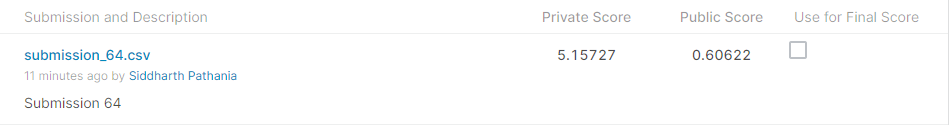

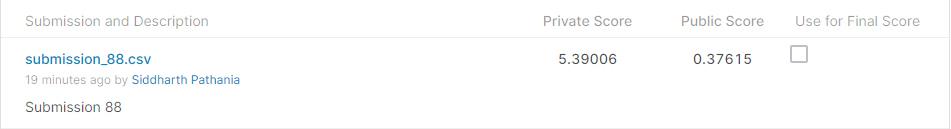

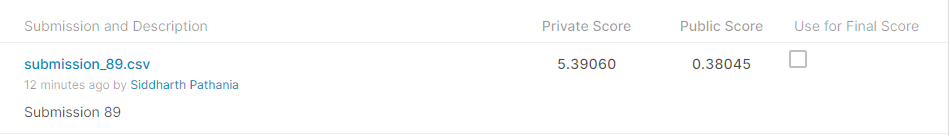

### LGBM on different categories

In [ ]:
# X_valid

In [ ]:


# df_final_train = downcast(df_final)

# df_final_train = df_final[df_final['d'] > 900 ]
df_final_train = df_final

df_final_train = downcast(df_final_train)
# df_final_train = df_final_train[df_final_train['d'] > 500 ]

In [ ]:
del df,df_final,df_valid , df_test

# del df_final

gc.collect()

55

In [ ]:
# df_final_train.info()

In [ ]:
# df_final_train = downcast(df_final_train)


category :- 1
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.70011
[200]	valid_0's rmse: 1.64265
[300]	valid_0's rmse: 1.63331
[400]	valid_0's rmse: 1.63085
[500]	valid_0's rmse: 1.63001
[600]	valid_0's rmse: 1.62943
[700]	valid_0's rmse: 1.62926
[800]	valid_0's rmse: 1.62918
[900]	valid_0's rmse: 1.62904
[1000]	valid_0's rmse: 1.62892
[1100]	valid_0's rmse: 1.6288
[1200]	valid_0's rmse: 1.62866
Early stopping, best iteration is:
[1162]	valid_0's rmse: 1.62863
category :- 2
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.53022
[200]	valid_0's rmse: 1.42571
[300]	valid_0's rmse: 1.40941
[400]	valid_0's rmse: 1.40611
[500]	valid_0's rmse: 1.40493
[600]	valid_0's rmse: 1.40404
[700]	valid_0's rmse: 1.40293
[800]	valid_0's rmse: 1.40213
[900]	valid_0's rmse: 1.40152
[1000]	valid_0's rmse: 1.40096
[1100]	valid_0's rmse: 1.40049
[1200]	valid_0's rmse: 1.39985
[1300]	valid_0's rmse: 1.39922
[1400]	valid_0's rmse: 1.3

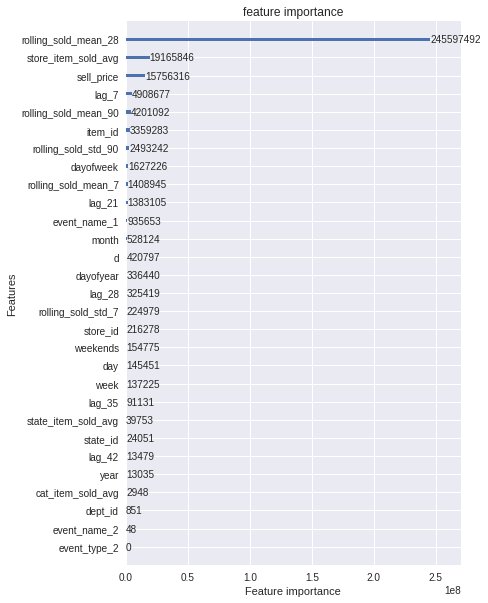

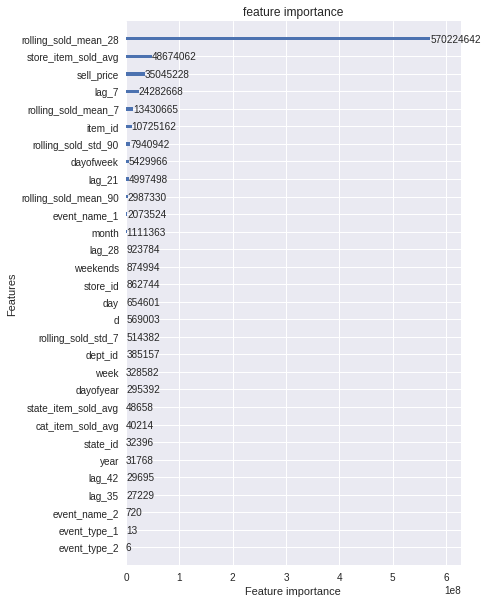

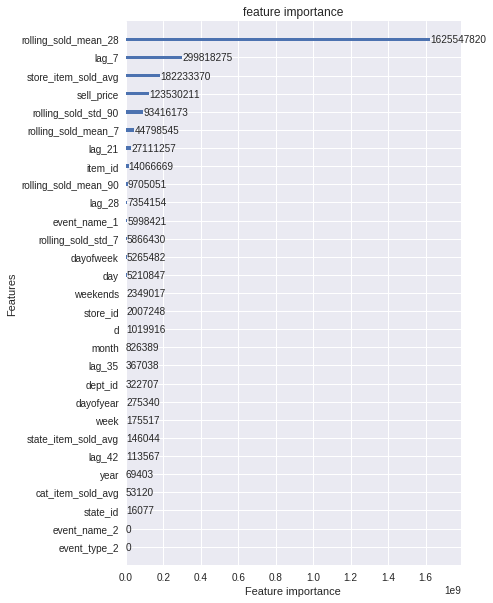

In [ ]:

# category_cols = ['item_id','dept_id','cat_id','store_id','state_id','event_name_1','event_type_1','wday','month','week','mday']

category_cols = ['item_id','dept_id','cat_id','store_id','state_id','event_name_1','event_type_1']


for i in categories :

    print("category :-" , i)
    df_cat = df_final_train[df_final_train['cat_id'] == i]

    test = X_test[X_test['cat_id'] == i]


    df_train = df_cat[df_cat['d']<1914]
    df_valid = df_cat[(df_cat['d']>=1914) & (df_cat['d']<1942)]


    train = lgb.Dataset(df_train.drop('sold' , axis =1 ), df_train['sold'], categorical_feature = category_cols)
        
    valid = lgb.Dataset(df_valid.drop('sold' , axis =1 ), df_valid['sold'], categorical_feature = category_cols)
    
    params = {
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'objective': 'poisson',
        'bagging_fraction': 0.6, # bootstrap sampling
        'bagging_freq' : 1,
        'colsample_bytree': 0.6, # feature sampling
        'max_depth': 200, # max depth of decision trees
        'num_leaves': 100,  #  number of leaves
         'learning_rate' : 0.05
          }

    model = lgb.train( params  , train_set = train , early_stopping_rounds = 50, 
                          valid_sets = valid, verbose_eval = 100, num_boost_round = 2000 )
    

    lgb.plot_importance(model, importance_type = 'gain', precision = 0,
                            figsize = (6, 10), 
                            title = 'feature importance') 

    
    # model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)] )

    y_valid_pred[df_valid.index] = model.predict(df_valid.drop('sold' , axis =1 ))

    y_test[test.index] = model.predict(test)  

    

    del model ,df_train, df_cat , train,df_valid,valid , test 
    gc.collect()
  # y_train_pred = model.predict(X_train)

  # y_valid_pred = model.predict(X_valid)




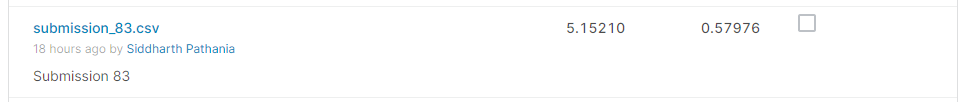

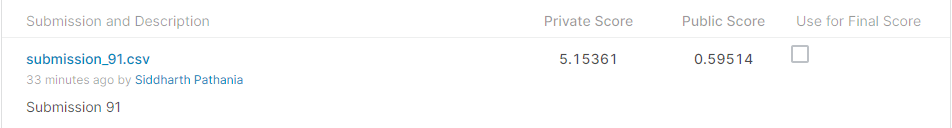

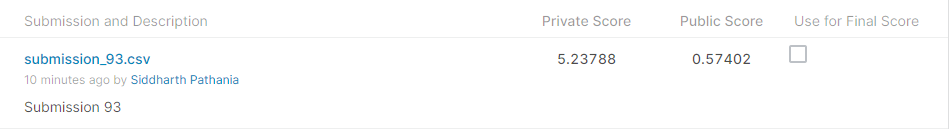

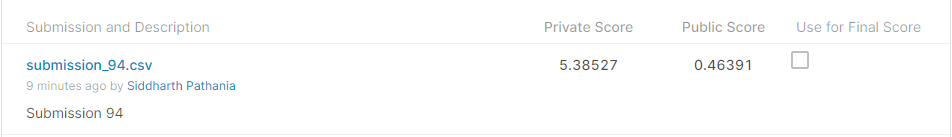

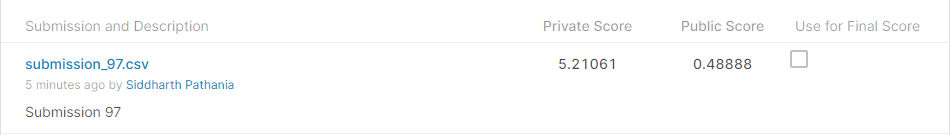

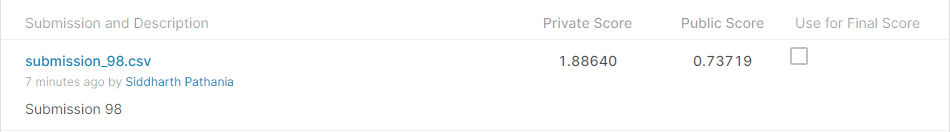

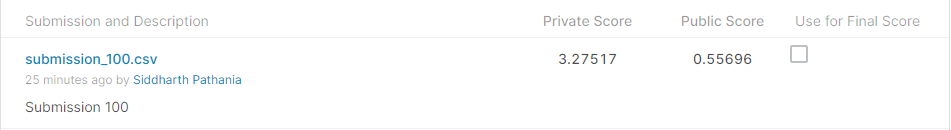

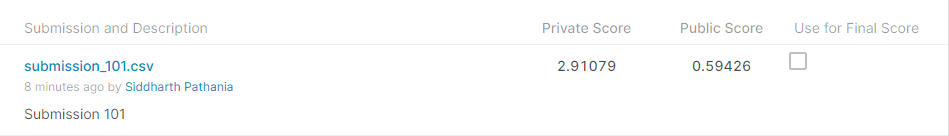

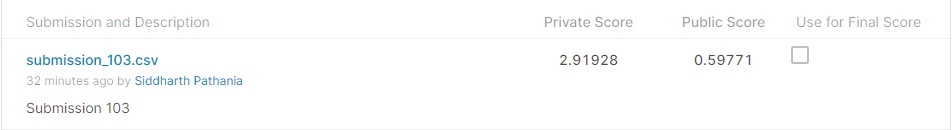

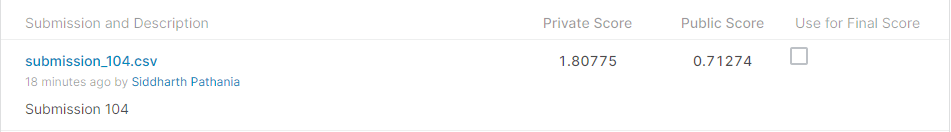

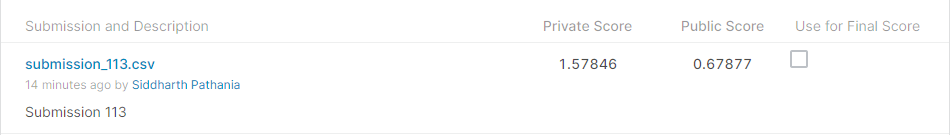

### LGBM on different stores

store :- 0
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 2.18808
[200]	valid_0's rmse: 2.15993
[300]	valid_0's rmse: 2.15312
[400]	valid_0's rmse: 2.14899
[500]	valid_0's rmse: 2.14696
Early stopping, best iteration is:
[505]	valid_0's rmse: 2.14679
store :- 1
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 2.03823
[200]	valid_0's rmse: 1.9991
Early stopping, best iteration is:
[246]	valid_0's rmse: 1.99791
store :- 2
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 2.65634
[200]	valid_0's rmse: 2.64983
[300]	valid_0's rmse: 2.64255
[400]	valid_0's rmse: 2.63554
[500]	valid_0's rmse: 2.63145
[600]	valid_0's rmse: 2.63051
[700]	valid_0's rmse: 2.62651
[800]	valid_0's rmse: 2.6251
Early stopping, best iteration is:
[768]	valid_0's rmse: 2.6241
store :- 3
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.43762
[200]	valid_0's rmse: 1.42896
[300]	

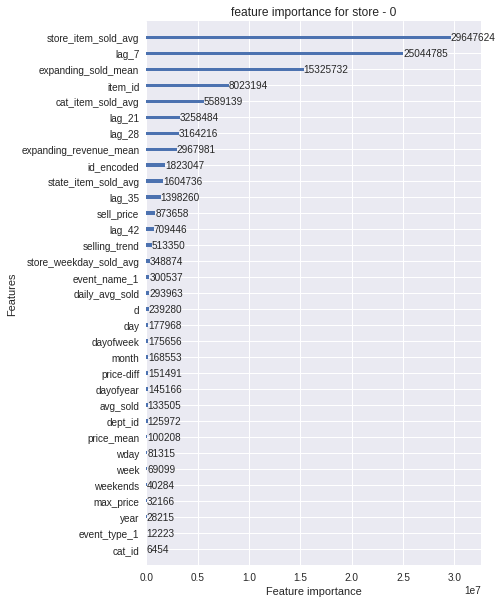

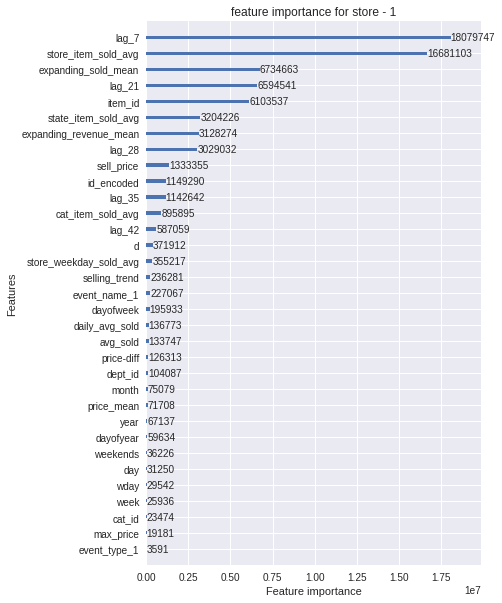

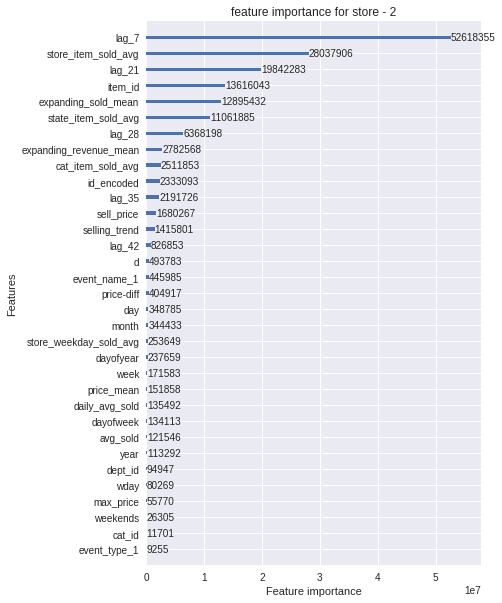

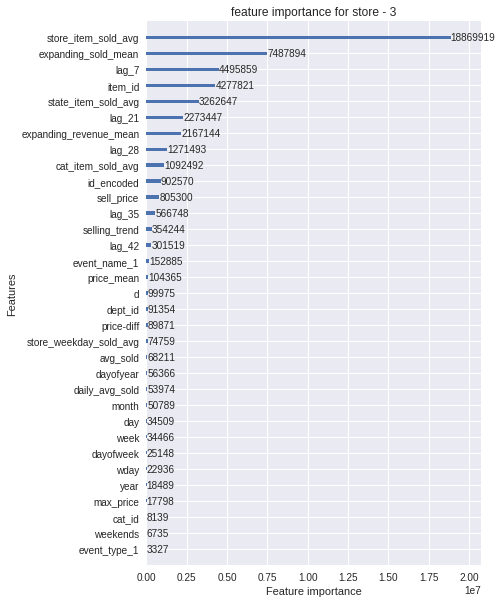

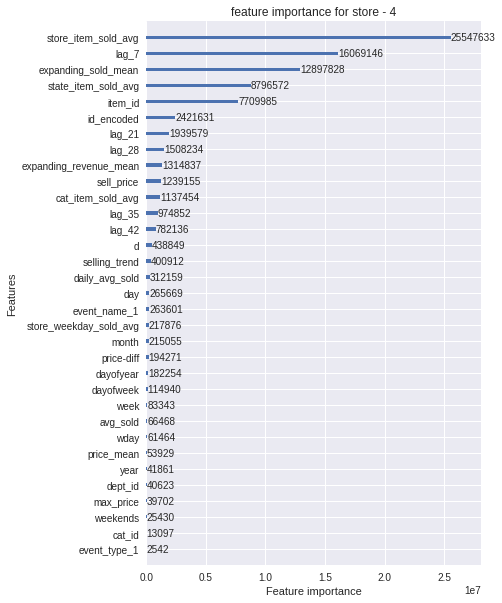

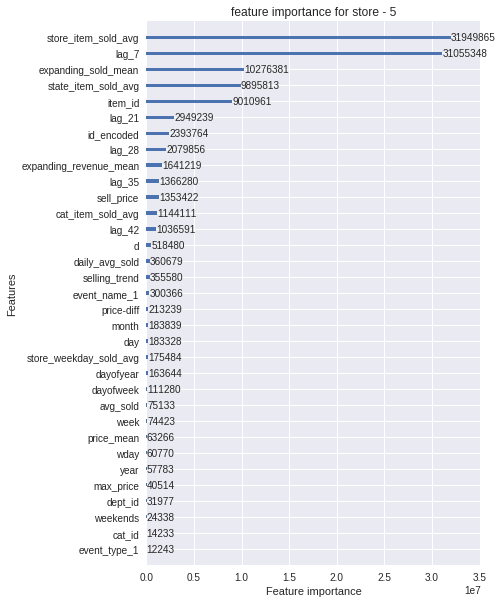

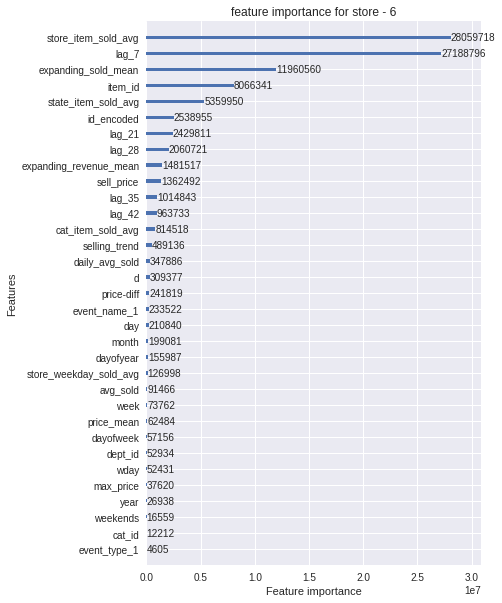

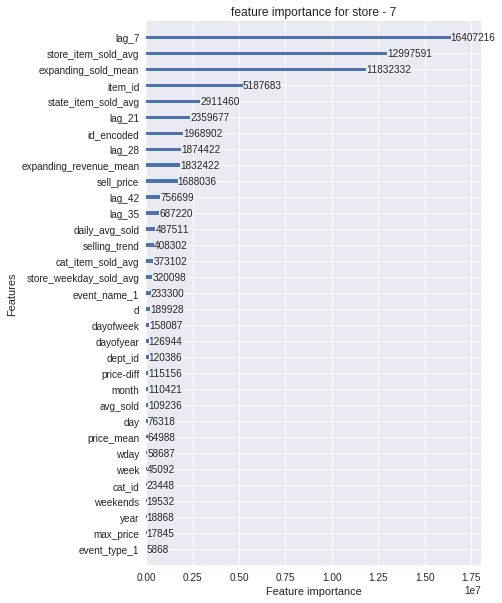

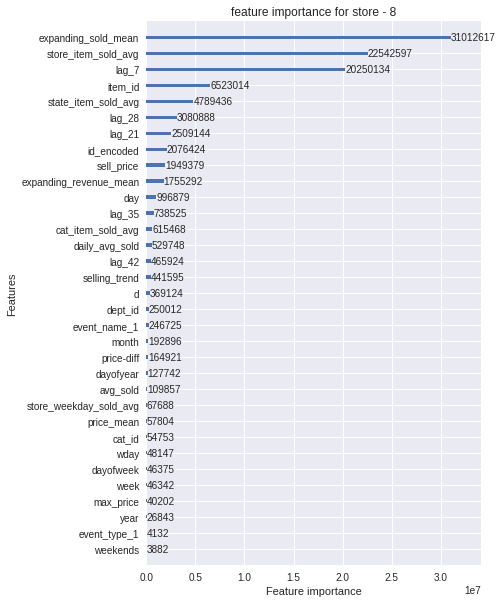

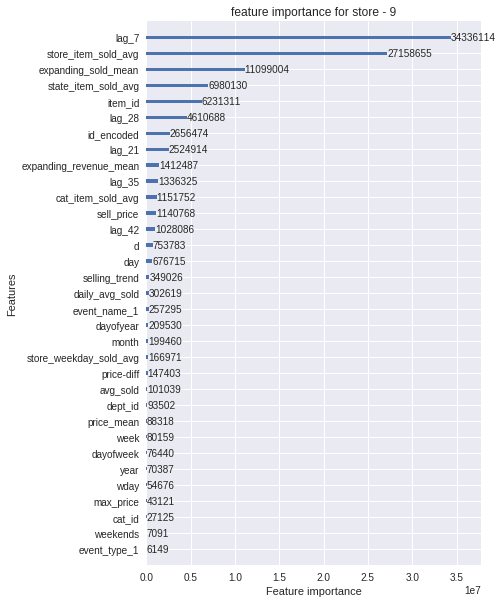

In [ ]:

category_cols = ['item_id','dept_id','cat_id','store_id','state_id','event_name_1','event_type_1']


for i in stores :

    print("store :-" , i)
    df_store = df_final_train[df_final_train['store_id'] == i]

    test = X_test[X_test['store_id'] == i]


    df_train = df_store[df_store['d']<1914]
    df_valid = df_store[(df_store['d']>=1914) & (df_store['d']<1942)]


    train = lgb.Dataset(df_train.drop('sold' , axis =1 ), df_train['sold'], categorical_feature = category_cols)
        
    valid = lgb.Dataset(df_valid.drop('sold' , axis =1 ), df_valid['sold'], categorical_feature = category_cols)
    
    params = {
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'objective': 'poisson',
        'bagging_fraction': 0.6, # bootstrap sampling
        'bagging_freq' : 1,
        'colsample_bytree': 0.6, # feature sampling
        'max_depth': 200, # max depth of decision trees
        'num_leaves': 100,  #  number of leaves
         'learning_rate' : 0.05 }

    model = lgb.train( params  , train_set = train , early_stopping_rounds = 50, 
                          valid_sets = valid, verbose_eval = 100, num_boost_round = 1500 )
    

    lgb.plot_importance(model, importance_type = 'gain', precision = 0,
                            figsize = (6, 10), 
                            title = f'feature importance for store - {i}') 


    y_valid_pred[df_valid.index] = model.predict(df_valid.drop('sold' , axis =1 ))

    y_test[test.index] = model.predict(test)  

    model.save_model(f'model{i}.lgb')

    del model ,df_train, df_store , train,df_valid,valid , test 
    gc.collect()




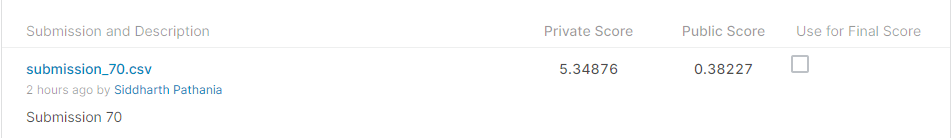

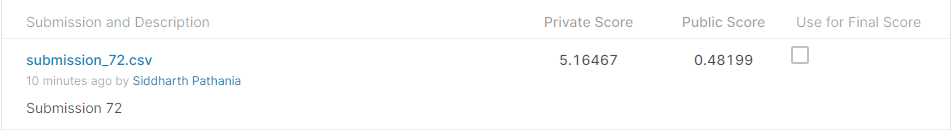

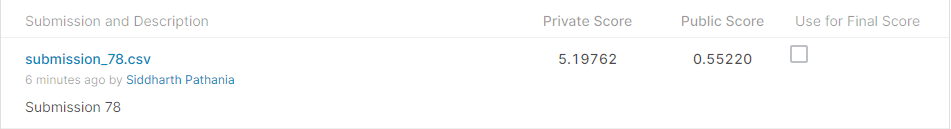

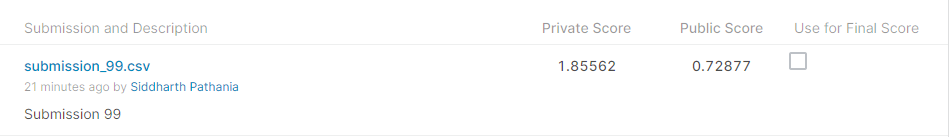

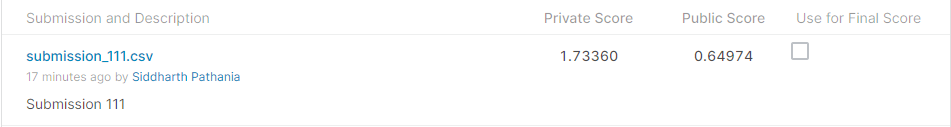

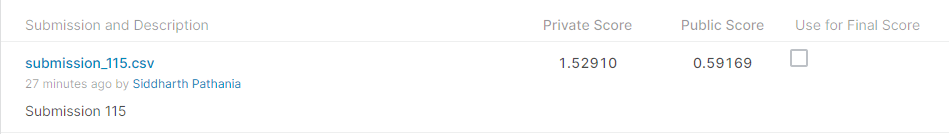

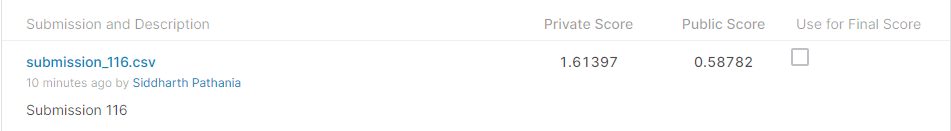

In [ ]:
gc.collect()

94335

In [ ]:
# df_final_train 

### LGBM Regressor with CV fold

In [ ]:

df_train = df_final[ (df_final['d'] > 600) & (df_final['d']<1942)]

df_train = downcast(df_train)

x_train , y_train = df_train.drop('sold',axis=1) , df_train['sold']



In [ ]:
# To clear the ram

del df,df_final,df_valid , df_test ,df_train

gc.collect()


97

Fold: 1
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's rmse: 3.07784
[100]	valid_0's rmse: 2.96086
[150]	valid_0's rmse: 2.94903
[200]	valid_0's rmse: 2.94763
[250]	valid_0's rmse: 2.94296
[300]	valid_0's rmse: 2.94106
[350]	valid_0's rmse: 2.93843
[400]	valid_0's rmse: 2.93686
[450]	valid_0's rmse: 2.93559
[500]	valid_0's rmse: 2.93194
[550]	valid_0's rmse: 2.93005
[600]	valid_0's rmse: 2.92874
[650]	valid_0's rmse: 2.92833
Early stopping, best iteration is:
[620]	valid_0's rmse: 2.92793
Fold: 2
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's rmse: 2.76958
[100]	valid_0's rmse: 2.69858
[150]	valid_0's rmse: 2.69592
[200]	valid_0's rmse: 2.69574
[250]	valid_0's rmse: 2.69252
[300]	valid_0's rmse: 2.68469
[350]	valid_0's rmse: 2.68248
[400]	valid_0's rmse: 2.67901
[450]	valid_0's rmse: 2.67149
[500]	valid_0's rmse: 2.67142
Early stopping, best iteration is:
[475]	valid_0's rmse: 2.67101
Fold: 3
Training until validation scores d

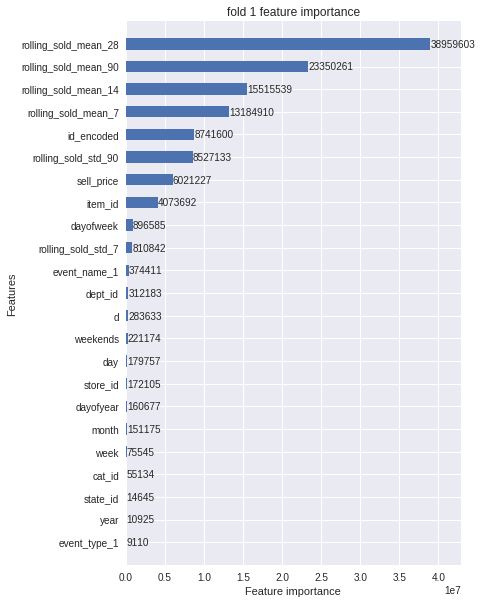

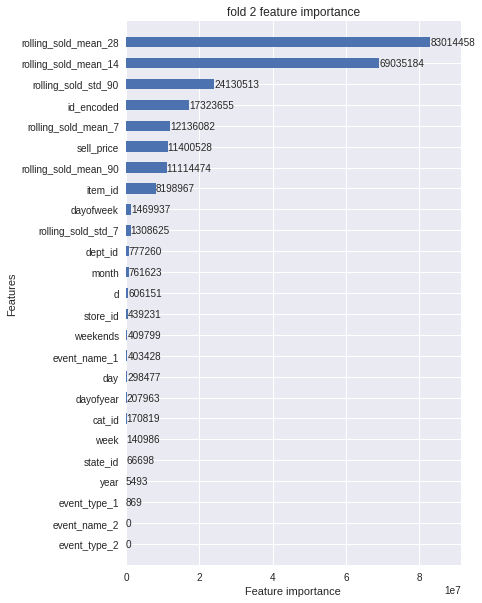

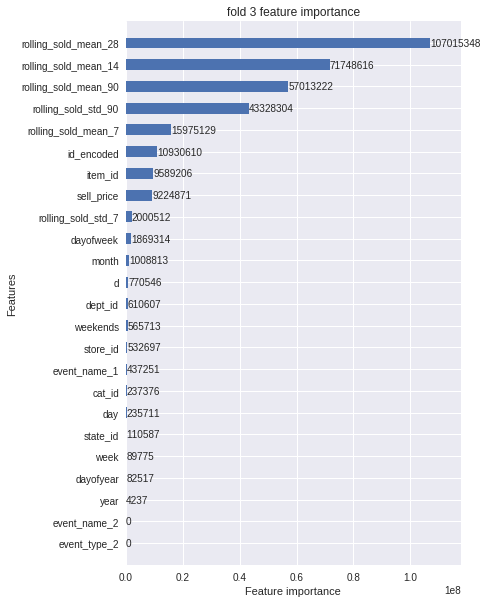

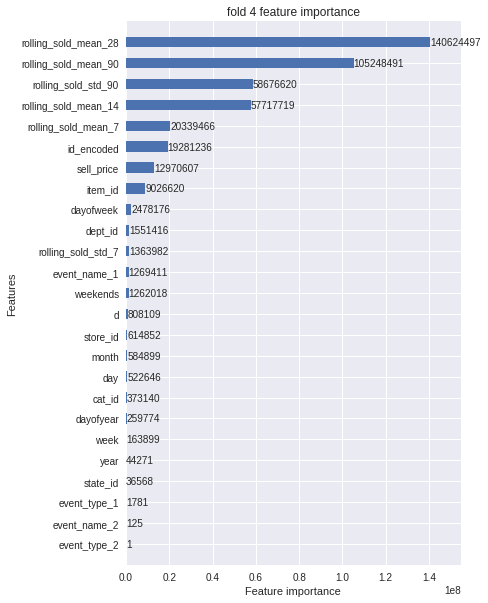

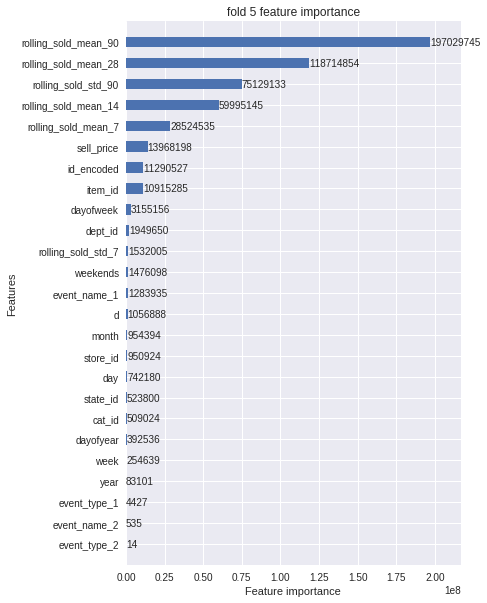

In [ ]:

## Ref. link :- https://www.kaggle.com/ratan123/m5-forecasting-lightgbm-with-timeseries-splits

## Ref. link :- https://www.kaggle.com/rikdifos/timeseriessplit-cv-poisson


category_cols = ['id_encoded','item_id','dept_id','cat_id','store_id','state_id','event_name_1','event_type_1']



# To avoid crashing of memory keep max depth low and number of leaves less
params = {
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'objective': 'poisson',
        'max_depth': 5, # max depth of decision trees
        'num_leaves': 64,  #  number of leaves

        'bagging_fraction': 0.6, # bootstrap sampling
        'bagging_freq' : 1,
        'colsample_bytree': 0.6, # feature sampling
        'learning_rate' : 0.05

        }

# n_fold = 3
n_fold = 5
# n_fold = 6
# n_fold = 8

folds = TimeSeriesSplit(n_splits=n_fold)
splits = folds.split(x_train , y_train)
feature_importance_df = pd.DataFrame()


for fold_n, (train_index, valid_index) in enumerate(splits):

    print('Fold:',fold_n+1)

    # training and validation sets for model training 

    train_set = lgb.Dataset(x_train.iloc[train_index] , y_train.iloc[train_index], categorical_feature = category_cols)
        
    val_set = lgb.Dataset(x_train.iloc[valid_index] , y_train.iloc[valid_index], categorical_feature = category_cols)

    model = lgb.train(params, train_set, valid_sets = [val_set] , early_stopping_rounds = 50 ,verbose_eval = 50 ,num_boost_round = 1000, )


    lgb.plot_importance(model, importance_type = 'gain', precision = 0,
                            height = 0.5, figsize = (6, 10), 
                            title = f'fold {fold_n+1} feature importance', ignore_zero = True) 
    

    fold_importance_df = pd.DataFrame()
    fold_importance_df['feature'] = x_train.columns
    fold_importance_df['importance'] = model.feature_importance(importance_type = 'gain')
    fold_importance_df['fold'] = fold_n + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


    y_valid_pred[X_valid.index] = model.predict(X_valid)

    y_test[X_test.index] += model.predict(X_test) /n_fold 

    # Saving the models
    model.save_model(f'model{fold_n+1}.lgb')

    del  train_set,val_set 

    gc.collect()

model.save_model('model.lgb')







Text(0.5, 1.0, 'LightGBM Features (averaged over folds)')

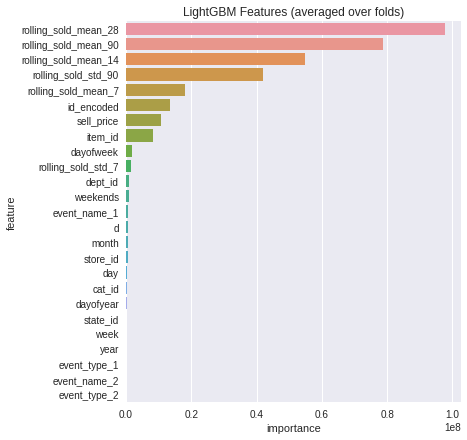

In [ ]:
feature_importance = (feature_importance_df[['feature', 'importance']]
        .groupby('feature')
        .mean()
        .sort_values(by='importance', ascending=False))
feature_importance['feature'] = feature_importance.index
plt.figure(figsize=(6,7))
sns.barplot(x='importance', y='feature', data=feature_importance[:40])
plt.title('LightGBM Features (averaged over folds)')

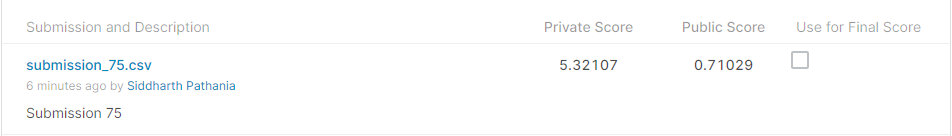

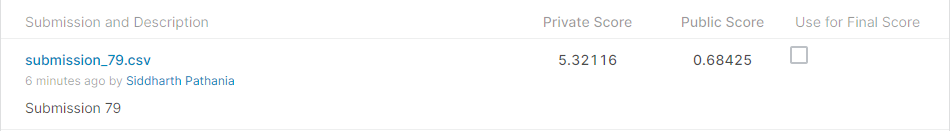

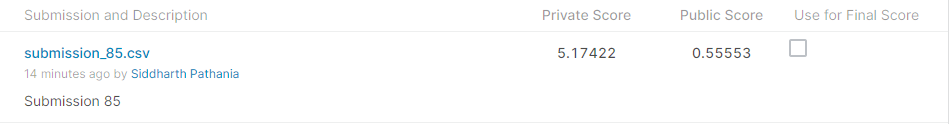

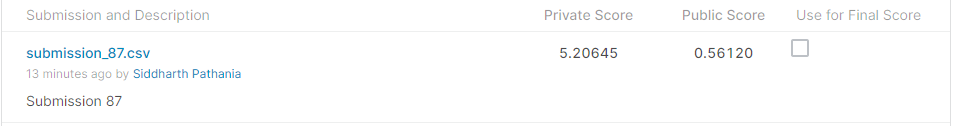

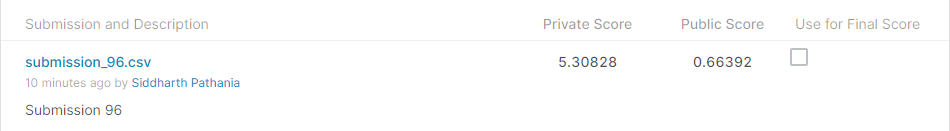

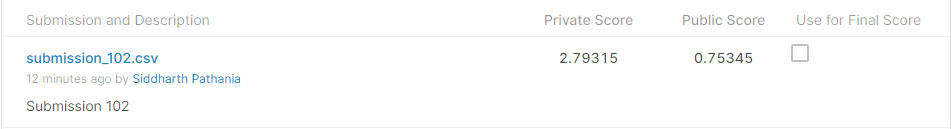

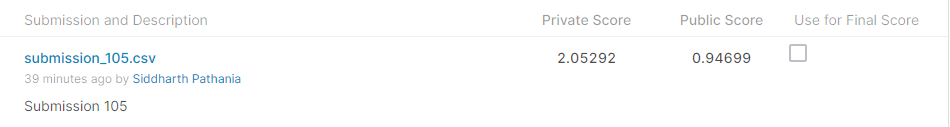

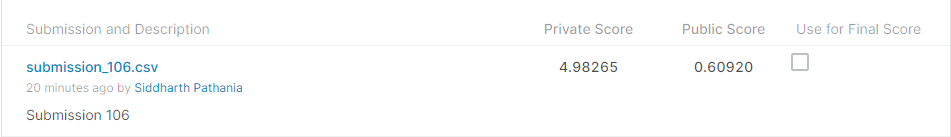

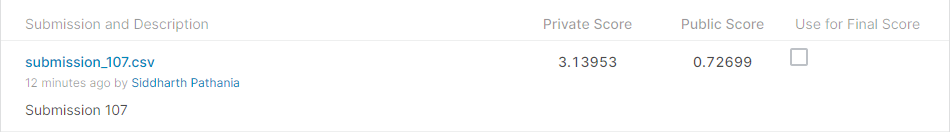

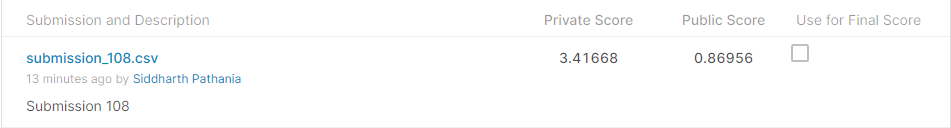

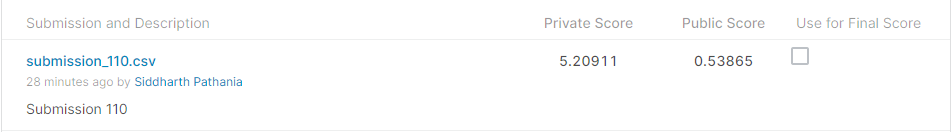

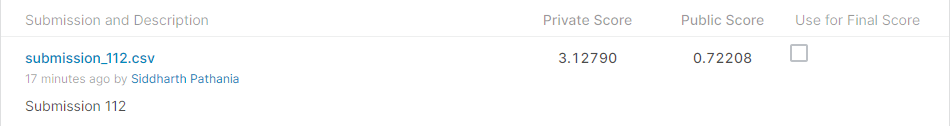

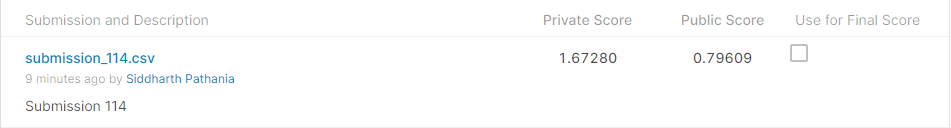

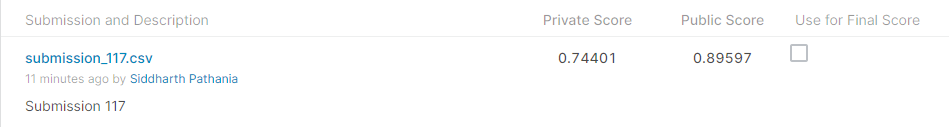

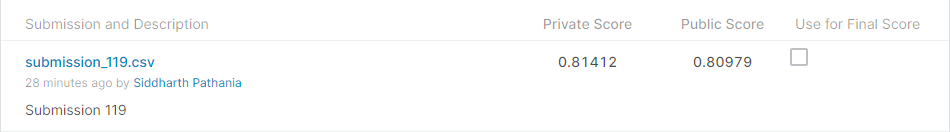

##### Best Result

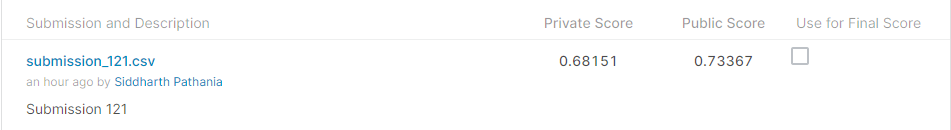

### XGBoost Regressor

In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor 

In [ ]:
df_final_train = downcast(df_final)

In [ ]:
category_cols = [ "item_id", "dept_id", "store_id", "cat_id", "state_id" , "event_name_1", "event_type_1", "event_name_2", "event_type_2","wday","month"]


for i in category_cols:

  # Training data
  df_final_train[i] = pd.to_numeric(df_final_train[i])

  # Valid for submission 
  X_valid[i] = pd.to_numeric(X_valid[i])

  # Test data for submission
  X_test[i] = pd.to_numeric(X_test[i])



In [ ]:
# df_final_train 
df_final_train = downcast(df_final_train)

In [ ]:
df_final_train = df_final_train[ df_final_train['d']>= 1200 ]

df_final_train = downcast(df_final_train)

In [ ]:
del df,df_final,df_valid , df_test

gc.collect()

11

store :- 0
[0]	test-rmse:3.70154	train-rmse:3.80611
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 5 rounds.
[10]	test-rmse:3.25889	train-rmse:3.35842
[20]	test-rmse:2.92061	train-rmse:3.01386
[30]	test-rmse:2.66772	train-rmse:2.75457
[40]	test-rmse:2.48068	train-rmse:2.56021
[49]	test-rmse:2.35663	train-rmse:2.42815
store :- 1
[0]	test-rmse:3.28405	train-rmse:2.76585
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 5 rounds.
[10]	test-rmse:2.91283	train-rmse:2.47191
[20]	test-rmse:2.62821	train-rmse:2.24971
[30]	test-rmse:2.41484	train-rmse:2.08624
[40]	test-rmse:2.25839	train-rmse:1.96593
[49]	test-rmse:2.15492	train-rmse:1.88717
store :- 2
[0]	test-rmse:4.97324	train-rmse:5.68336
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 5 

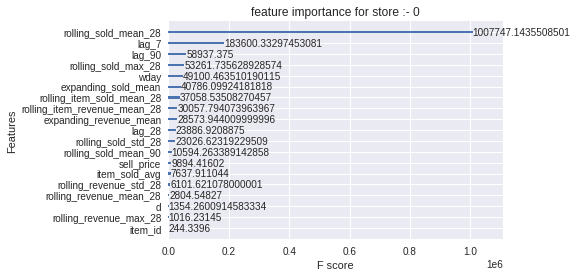

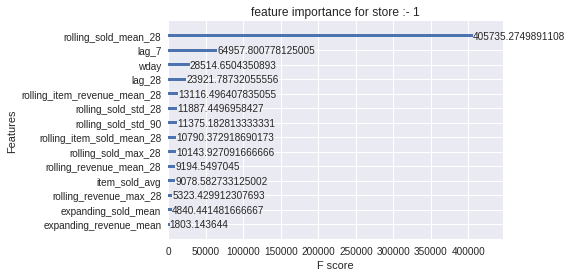

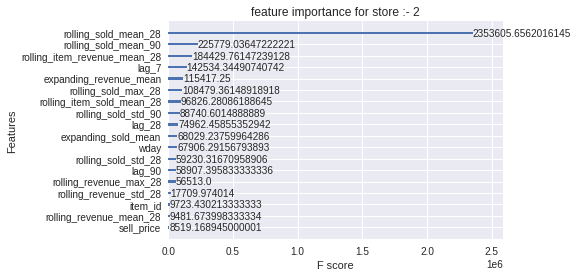

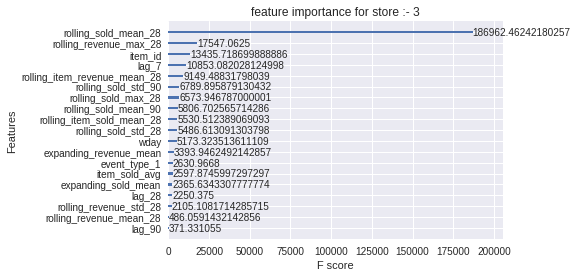

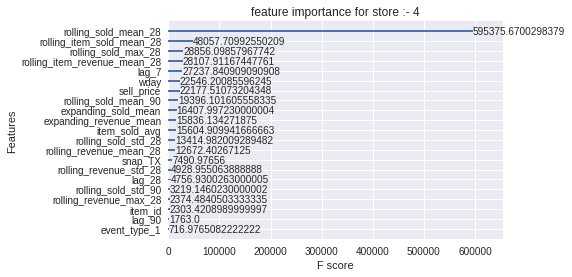

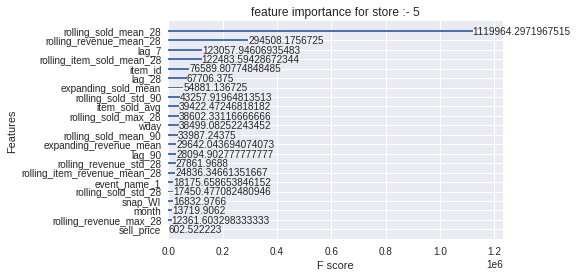

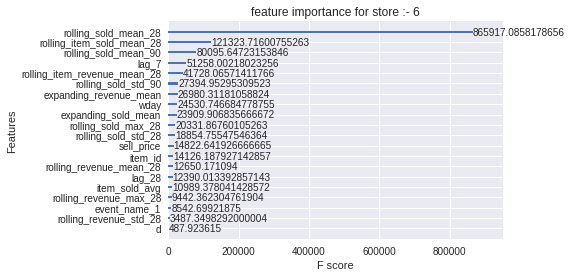

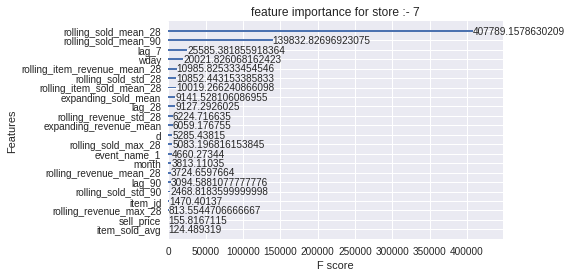

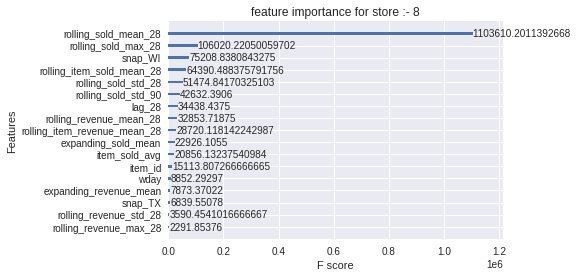

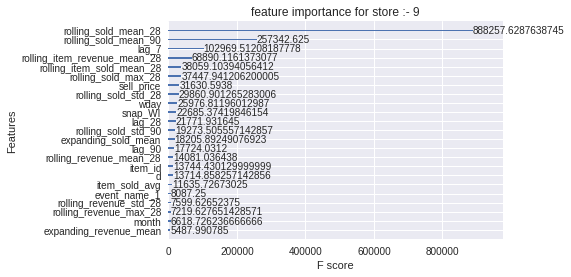

In [ ]:



for i in stores :

    print("store :-" , i)
    df_cat = df_final_train[df_final_train['store_id'] == i]

    test = X_test[X_test['store_id'] == i]


    df_train = df_cat[  df_cat['d']<1914 ] # to avoid ram crashing
    df_valid = df_cat[(df_cat['d']>=1914) & (df_cat['d']<1942)]


    train = xgb.DMatrix(df_train.drop('sold' , axis =1 ), df_train['sold'])
        
    valid = xgb.DMatrix(df_valid.drop('sold' , axis =1 ), df_valid['sold'])
    
    params = {
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'obj': 'poisson',
        'max_depth': 5, # max depth of decision trees
        'num_leaves': 32,  #  number of leaves
         'learning_rate' : 0.02  }


    watchlist = [(valid, 'test'), (train, 'train')]

    
    model = xgb.train( params , train , num_boost_round = 50 , early_stopping_rounds=5 , verbose_eval= 10 , evals = watchlist,  )
    

    xgb.plot_importance(model, title = f'feature importance for store :- {i}'  , importance_type= 'gain') 

    y_valid_pred[df_valid.index] = model.predict(xgb.DMatrix(df_valid.drop('sold' , axis =1 )))

    y_test[test.index] = model.predict(xgb.DMatrix(test))  

    

    del model ,df_train, df_cat , train,df_valid,valid , test 
    gc.collect()




In [ ]:
gc.collect()

52864

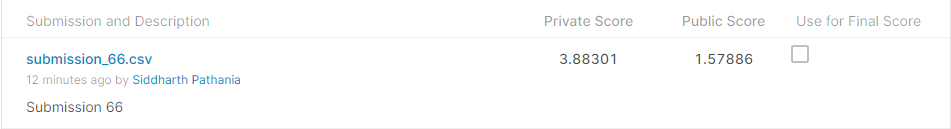

### XGBoost Regressor with CV fold

Fold: 1
[12:54:55] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	test-rmse:3.70692	train-rmse:3.38599
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 5 rounds.
[10]	test-rmse:3.29457	train-rmse:3.02138
[20]	test-rmse:2.98271	train-rmse:2.74455
[30]	test-rmse:2.74994	train-rmse:2.53963
[40]	test-rmse:2.5766	train-rmse:2.3875
[49]	test-rmse:2.46109	train-rmse:2.28629
Fold: 2
[13:09:35] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	test-rmse:3.50797	train-rmse:3.54244
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't 

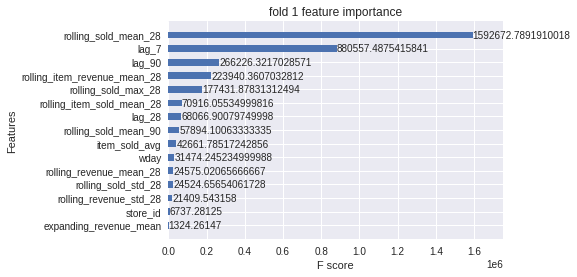

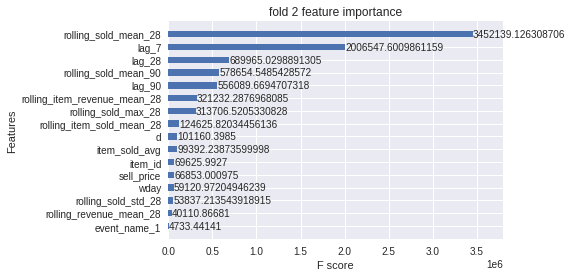

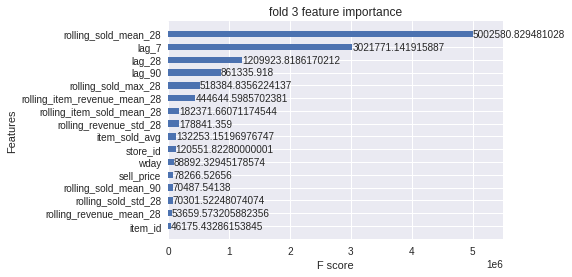

In [ ]:
## Ref. link :- https://www.kaggle.com/ratan123/m5-forecasting-lightgbm-with-timeseries-splits


df_final_train = df_final_train[ df_final_train['d']>= 1400 ]


# To avoid crashing of memory keep max depth low and number of leaves less
params = {
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'obj': 'poisson',
        'max_depth': 5, # max depth of decision trees
        'num_leaves': 64,  #  number of leaves
         'learning_rate' : 0.02 

        }

n_fold = 3
# n_fold = 5
# n_fold = 8

x_train , y_train = df_final_train.drop('sold' , axis = 1)  , df_final_train['sold']

folds = TimeSeriesSplit(n_splits=n_fold)
splits = folds.split(x_train , y_train)
feature_importance_df = pd.DataFrame()


for fold_n, (train_index, valid_index) in enumerate(splits):

    print('Fold:',fold_n+1)

    # training and validation sets for model training 

    train = xgb.DMatrix(x_train.iloc[train_index] , y_train.iloc[train_index] )
        
    valid = xgb.DMatrix(x_train.iloc[valid_index] , y_train.iloc[valid_index] )


    watchlist = [(valid, 'test'), (train, 'train')]

    
    model = xgb.train( params , train , num_boost_round = 50 , early_stopping_rounds=5 , verbose_eval= 10 , evals = watchlist,  )


    xgb.plot_importance(model, importance_type = 'gain',height = 0.5, 
                            title = f'fold {fold_n+1} feature importance'  ) 
    

    y_valid_pred[X_valid.index] += model.predict(xgb.DMatrix(X_valid)) / n_fold

    y_test[X_test.index] += model.predict(xgb.DMatrix(X_test))  / n_fold

    # save model to file
    pickle.dump(model, open(f'model{fold_n+1}.pkl' , "wb"))

    del  train ,valid 

    gc.collect()

pickle.dump( model , open('model.pkl' , "wb"))


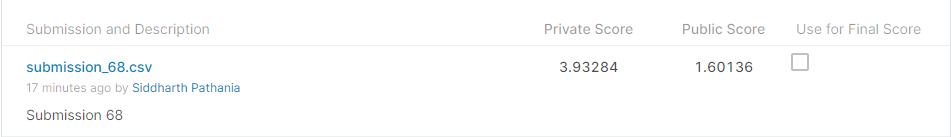

# Get submission file

In [ ]:
# X_test['d'].unique()
filename = 'features_1.pkl'

df = joblib.load(filename)

In [ ]:
# Get final dataframe with id.
df_final = df.drop(columns = ['date','weekday'])

df_valid = df_final[(df_final['d']>=1914) & (df_final['d']<1942)]
df_test = df_final[df_final['d']>=1942]


X_valid , y_valid = df_valid.drop('sold',axis=1), df_valid['sold']

X_test = df_test.drop('sold',axis=1)

In [ ]:
X_test


,id,item_id,dept_id,cat_id,store_id,state_id,d,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,revenue,lag_7,lag_21,lag_28,lag_35,lag_42,price-diff,rolling_sold_mean_7,rolling_sold_mean_28,rolling_sold_mean_90,rolling_sold_max_7,rolling_sold_max_28,rolling_sold_std_7,rolling_sold_std_28,rolling_sold_std_90,rolling_revenue_mean_28,rolling_revenue_max_28,rolling_revenue_std_28,rolling_item_revenue_mean_28,rolling_item_sold_mean_7,rolling_item_sold_mean_28,rolling_dept_sold_mean_28,rolling_store_sold_mean_28,item_sold_avg,store_sold_avg,state_sold_avg,store_item_sold_avg,cat_item_sold_avg,state_item_sold_avg,store_weekday_sold_avg,max_price,min_price,price_mean,price_std,price_norm,daily_avg_sold,avg_sold,selling_trend,expanding_sold_mean,expanding_revenue_mean,week,day,dayofweek,dayofyear,weekends
59181090,HOBBIES_1_001_CA_1_evaluation,1437,3,1,0,0,1942,11617,3,5,2016,No_event,No_event,No_event,No_event,0,0,0,8.382812,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.000000,0.928711,0.966797,3.0,4.0,1.000000,1.152344,1.085938,7.742188,33.031250,9.578125,6.550781,0.856934,0.785645,0.750000,3.392578,0.216553,1.304688,1.215820,0.321533,0.216553,0.335938,1.250000,9.578125,0.0,4.484375,4.136719,0.875000,8.382812,4.515625,3.867188,0.325928,2.695312,21,23,0,144,0
59181091,HOBBIES_1_002_CA_1_evaluation,1438,3,1,0,0,1942,11617,3,5,2016,No_event,No_event,No_event,No_event,0,0,0,3.970703,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.142822,0.035706,0.188843,1.0,1.0,0.377930,0.188965,0.393555,0.141846,3.970703,0.750488,0.708984,0.285645,0.178589,0.714355,3.392578,0.259766,1.304688,1.215820,0.253906,0.259766,0.204346,1.250000,3.970703,0.0,3.826172,0.741211,1.000000,3.970703,3.687500,0.283203,0.257568,1.022461,21,23,0,144,0
59181092,HOBBIES_1_003_CA_1_evaluation,1439,3,1,0,0,1942,11617,3,5,2016,No_event,No_event,No_event,No_event,0,0,0,2.970703,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.714355,0.571289,0.455566,1.0,2.0,0.488037,0.689941,0.823242,1.697266,5.941406,2.050781,1.273438,0.714355,0.428467,0.500000,3.357422,0.076660,1.304688,1.215820,0.156982,0.076660,0.098938,1.250000,5.968750,0.0,1.250977,1.467773,0.497803,2.970703,1.312500,1.658203,0.159058,0.472656,21,23,0,144,0
59181093,HOBBIES_1_004_CA_1_evaluation,1440,3,1,0,0,1942,11617,3,5,2016,No_event,No_event,No_event,No_event,0,0,0,4.640625,0.0,4.0,4.0,0.0,4.0,2.0,0.0,2.000000,1.821289,2.011719,7.0,7.0,2.449219,1.886719,1.905273,8.453125,32.500000,8.757812,4.972656,0.714355,1.071289,0.500000,3.392578,2.011719,1.304688,1.215820,1.694336,2.011719,2.935547,1.250000,4.640625,0.0,4.468750,0.445801,1.000000,4.640625,4.449219,0.191406,1.718750,7.835938,21,23,0,144,0
59181094,HOBBIES_1_005_CA_1_evaluation,1441,3,1,0,0,1942,11617,3,5,2016,No_event,No_event,No_event,No_event,0,0,0,2.880859,0.0,2.0,2.0,1.0,0.0,2.0,0.0,1.857422,1.357422,1.200195,4.0,4.0,1.069336,1.283203,1.191406,3.910156,11.523438,3.695312,2.333984,1.142578,0.821289,0.535645,3.285156,0.755371,1.304688,1.215820,0.958984,0.755371,0.968750,1.250000,3.080078,0.0,2.716797,0.687012,0.935547,2.880859,2.773438,0.107422,0.972168,2.857422,21,23,0,144,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60034805,FOODS_3_823_WI_3_evaluation,1432,2,0,9,2,1969,11621,2,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,2.980469,0.0,0.0,0.0,1.0,3.0,1.0,0.0,0.571289,0.643066,0.366699,1.0,3.0,0.534668,0.826172,0.677734,1.916016,8.937500,2.462891,0.000000,0.000000,0.000000,0.000000,0.000000,0.797852,1.089844,1.027344,0.528320,0.797852,0.492432,1.256836,2.980469,0.0,2.675781,0.596680,1.000000,2.980469,2.800781,0.179688,0.528320,1.429688,24,19,6,171,1
60034806,FOODS_3_824_WI_3_evaluation,1433,2,0,9,2,1969,11621,2,6,2016,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0,2.480469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.285645,0.285645,0.1

In [ ]:
# Making submission for validation dataset

X_valid['sold'] = y_valid_pred

submission_1 = X_valid[['id','d' ,'sold']]

submission_1 = pd.pivot(submission_1, index='id', columns='d', values='sold').reset_index()

# Ref. link :- https://stackoverflow.com/questions/28986489/how-to-replace-text-in-a-column-of-a-pandas-dataframe
submission_1['id'] = submission_1['id'].str.replace('_evaluation','_validation')

submission_1.columns=['id'] + ['F' + str(i + 1) for i in range(28)]

In [ ]:
submission_1 

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,1.090049,0.691359,0.757798,0.467963,0.880220,0.822549,0.869024,1.077544,0.745053,0.843817,0.569883,0.806409,0.988769,0.759611,0.964332,0.871077,0.786037,0.545071,0.973134,0.884817,0.621560,0.988105,0.726447,0.700440,0.522933,0.859434,1.171695,0.907705
1,FOODS_1_001_CA_2_validation,1.081022,1.058795,1.050121,1.032109,0.509392,0.877374,1.635482,0.903649,1.165368,1.038578,0.492967,0.901509,1.333790,2.091046,0.704647,0.908417,1.064699,0.914405,0.843067,0.532985,1.750178,0.972949,1.244448,1.190531,0.916545,1.044101,0.991028,1.842502
2,FOODS_1_001_CA_3_validation,0.954654,0.607795,0.762436,0.677451,0.907921,1.452345,1.479168,0.974991,0.597983,0.853828,0.635886,1.231444,1.389026,1.600364,0.854475,0.851499,0.765683,0.536168,0.912310,1.235370,1.407986,0.987805,0.615230,0.738137,0.543699,1.074688,1.449785,1.682489
3,FOODS_1_001_CA_4_validation,0.462395,0.240622,0.364826,0.240954,0.381104,0.426914,0.403220,0.416210,0.370907,0.363762,0.244493,0.243980,0.329713,0.324751,0.430902,0.243157,0.329542,0.239156,0.318173,0.431987,0.341586,0.364258,0.318643,0.306151,0.239243,0.391977,0.348925,0.378251
4,FOODS_1_001_TX_1_validation,0.444126,0.446315,0.476044,0.359166,0.475025,0.395094,0.360159,0.408619,0.487089,0.551167,0.310741,0.538534,0.366705,0.595551,0.484296,0.535765,0.496642,0.328672,0.331730,0.661224,0.680997,0.315738,0.512230,0.428157,0.463070,0.501498,0.595281,0.635343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.242864,0.237017,0.268691,0.264291,0.302106,0.262191,0.382331,0.287858,0.223361,0.210559,0.249801,0.242304,0.337092,0.369775,0.288580,0.213541,0.260428,0.211889,0.207243,0.365263,0.342245,0.232476,0.198853,0.215053,0.179653,0.217356,0.324961,0.353639
30486,HOUSEHOLD_2_516_TX_3_validation,0.118108,0.212519,0.214481,0.115412,0.127480,0.192615,0.150857,0.114484,0.223813,0.215625,0.110409,0.117337,0.267203,0.188710,0.208931,0.382089,0.352551,0.261267,0.222181,0.308128,0.248311,0.214902,0.206250,0.210616,0.221093,0.233120,0.196141,0.205456
30487,HOUSEHOLD_2_516_WI_1_validation,0.070076,0.070515,0.068988,0.069328,0.080053,0.105432,0.095166,0.094200,0.073120,0.067778,0.086447,0.094746,0.084465,0.077137,0.070289,0.070904,0.068840,0.069206,0.089860,0.119348,0.081942,0.086254,0.071851,0.070462,0.086957,0.094189,0.087419,0.083898
30488,HOUSEHOLD_2_516_WI_2_validation,0.043630,0.043630,0.043630,0.064170,0.045180,0.046810,0.048331,0.046043,0.046149,0.045662,0.045662,0.047024,0.048627,0.046423,0.044091,0.044581,0.044683,0.056013,0.046247,0.048309,0.047532,0.043615,0.043615,0.043615,0.053192,0.044978,0.046826,0.067529


In [ ]:
# Making submission for test dataset

X_test['sold'] = y_test

submission_2 = X_test[['id','d' ,'sold']]

submission_2 = pd.pivot(submission_2, index='id', columns='d', values='sold').reset_index()
submission_2.columns=['id'] + ['F' + str(i + 1) for i in range(28)]

In [ ]:
# Making final submission
submission = [submission_1 , submission_2]

final_submission_1 = pd.concat(submission)

final_submission_1.to_csv('submission_121.csv', index = False)